<a href="https://colab.research.google.com/github/fahriyegrl/model_deployment_Food101_effnetb2/blob/main/FoodVisio_Food101_ModelDeployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

## Creating a model by using torchvision.models.efficientnet_b2

# Getting the pretrained weights of the model:

effnetb2_weigths = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2_transforms = effnetb2_weigths.transforms()

effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [3]:
## Setting up the model

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weigths)

#Freeze all layers

for param in effnetb2.parameters():
  param.requires_grad =False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 37.8MB/s]


In [4]:
## Checking the model classifier
effnetb2.classifier


Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [5]:
## Changing out_features to 101 since there are 101 label in the Food101 datasets

effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=101))

effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=101, bias=True)
)

Turning cretaing a model to a function

In [6]:
def created_effnetb2_model(num_classess=101):
  weigths = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weigths.transforms()
  model = torchvision.models.efficientnet_b2(weights=weigths)
  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(42)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classess)
  )

  return model, transforms



In [7]:
#using summary to see if output size is changed
summary(effnetb2,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 101]        --              Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1408, 7, 7] --              False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --              False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)            False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --              --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --              False
│    │    └─MBConv (0)                                   

In [8]:
## Creating transforms for Food101 dataset by adding data augmentation

food101_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
    ])

print(food101_transforms)

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)


In [9]:
## Getting data from Food101
from pathlib import Path
data_directory = Path("data")

train_data = datasets.Food101(root=data_directory,
                              split="train",
                              transform=food101_transforms,
                              download=True)
test_data = datasets.Food101(root=data_directory,
                              split="test",
                              transform=effnetb2_transforms,
                              download=True)

100%|██████████| 4996278331/4996278331 [03:51<00:00, 21618432.61it/s]


Extracting data/food-101.tar.gz to data


In [10]:
food101_classes = train_data.classes
food101_classes[:15]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake']

In [11]:
train_length_1 = int(len(train_data) * 0.6)
train_length_2 = len(train_data)- train_length_1

test_length_1 = int(len(test_data) * 0.6)
test_length_2 = len(test_data)- test_length_1

train_data_split_1, train_data_split_2 = torch.utils.data.random_split(train_data,
                                                            lengths=[train_length_1, train_length_2],
                                                            generator=torch.manual_seed(42))

test_data_split_1, test_data_split_2 = torch.utils.data.random_split(test_data,
                                                            lengths=[test_length_1, test_length_2],
                                                            generator=torch.manual_seed(42))

In [12]:
## Turning the Food101 datates into DataLoader

BATCH_SIZE=32

train_dataloader = torch.utils.data.DataLoader(train_data_split_1,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_data_split_1,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)


In [13]:
## Training the model with Adam optimizer and CrossEntropyLoss loss function and using label smoothing

try:
  from going_modular.going_modular import data_setup, engine
except:
  print("[INFO] downloading going_modular from GitHub.")
  !git clone https://github.com/fahriyegrl/going_modular_pytorch
  !mv going_modular_pytorch/going_modular .
  !rm -rf going_modular_pytorch
  from going_modular.going_modular import data_setup,engine


optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

loss_fn= torch.nn.CrossEntropyLoss(label_smoothing=0.1)


[INFO] downloading going_modular from GitHub.
Cloning into 'going_modular_pytorch'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 8), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (24/24), 13.10 KiB | 6.55 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [14]:
torch.manual_seed(42)
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=5,
                                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1552 | train_acc: 0.3725 | test_loss: 2.3244 | test_acc: 0.5688
Epoch: 2 | train_loss: 2.6777 | train_acc: 0.4723 | test_loss: 2.2046 | test_acc: 0.5996
Epoch: 3 | train_loss: 2.6022 | train_acc: 0.4958 | test_loss: 2.1430 | test_acc: 0.6162
Epoch: 4 | train_loss: 2.5710 | train_acc: 0.5001 | test_loss: 2.1223 | test_acc: 0.6194
Epoch: 5 | train_loss: 2.5600 | train_acc: 0.5050 | test_loss: 2.1082 | test_acc: 0.6269


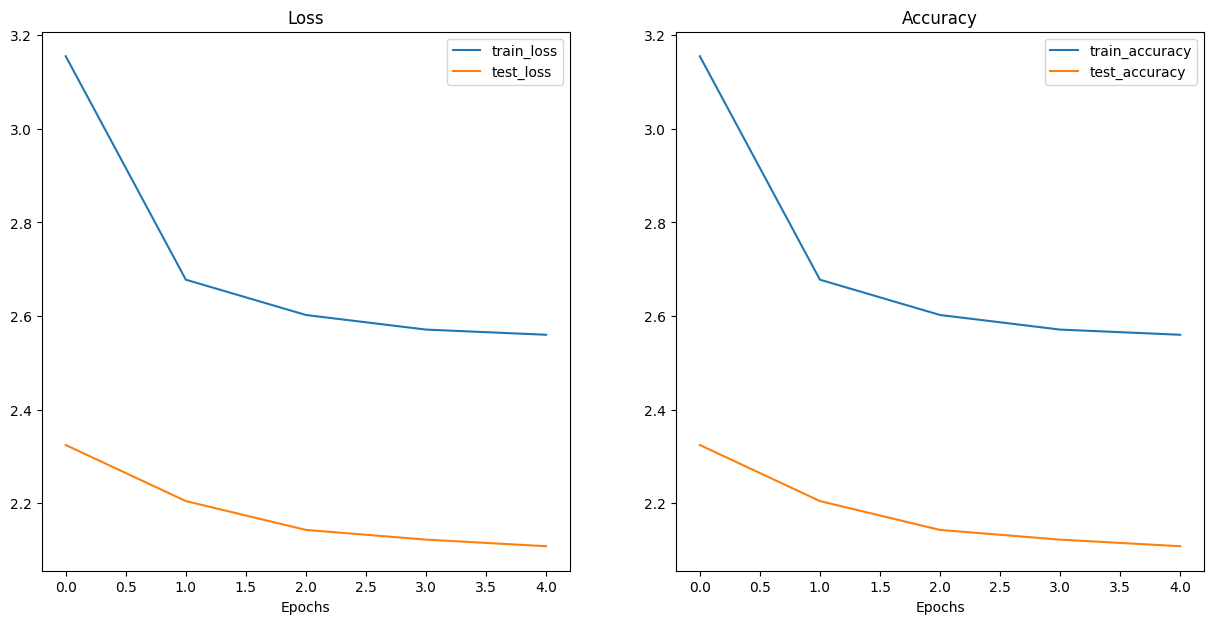

In [15]:
##Checking loss curves of the model
import matplotlib.pyplot as plt
import numpy as np

loss = effnetb2_results["train_loss"]
test_loss = effnetb2_results["test_loss"]

accurancy = effnetb2_results["train_acc"]
test_accurancy = effnetb2_results["test_acc"]

epochs = range(len(effnetb2_results["train_acc"]))

plt.figure(figsize=(15,7))
#Plotting loss
plt.subplot(1,2,1)
plt.plot(epochs, loss, label="train_loss")
plt.plot(epochs, test_loss, label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

#Plotting accuracy
plt.subplot(1,2,2)
plt.plot(epochs, loss, label="train_accuracy")
plt.plot(epochs, test_loss, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()


In [35]:
## Saving the model
model=effnetb2
effnetb2_model_name = "effnetb2_model_Food101.pth"

target_dir_path = Path("models")
target_dir_path.mkdir(parents=True,
                  exist_ok=True)

assert effnetb2_model_name.endswith(".pth") or effnetb2_model_name(".pt")
saving_model_path = target_dir_path / effnetb2_model_name

print("Saving the model....")
torch.save(obj=model.state_dict(),
           f=saving_model_path)


Saving the model....


In [17]:
print(type(torch.load))

<class 'function'>


In [43]:
loaded_effnetb2, loaded_effnetb2_transforms = created_effnetb2_model()


#loaded_effnetb2.load_state_dict(torch.load("models/effnetb2_model_Food101.pth"))

loaded_effnetb2.load_state_dict(torch.load("models/effnetb2_model_Food101.pth",
                                          map_location=torch.device("cpu")))


#effnetb2_model.load_state_dict(torch.load("effnetb2_model_Food101.pth",
                                        #  map_location=torch.device("cpu")))


<All keys matched successfully>

In [19]:
## Deployment the Model by Gradio on Hugging Face
# Createing a directory to store the model

from pathlib import Path

model_deploy_path = Path("demos/effnetb2_Food101/")
model_deploy_path.mkdir(parents=True,
                        exist_ok=True)

## Example directory

(model_deploy_path / "examples").mkdir(parents=True, exist_ok=True)



In [20]:
!wget https://github.com/fahriyegrl/model_deployment_Food101_effnetb2/blob/80ea348dbdb428dfd8ea4cb812b4bcd27671a8ef/images/IMG_1804.jpg
!mv IMG_1804.jpg demos/effnetb2_Food101/examples/IMG_1804.jpg


!mv models/effnetb2_model_Food101.pth  demos/effnetb2_Food101

--2024-07-21 20:05:53--  https://github.com/fahriyegrl/model_deployment_Food101_effnetb2/blob/80ea348dbdb428dfd8ea4cb812b4bcd27671a8ef/images/IMG_1804.jpg
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘IMG_1804.jpg’

IMG_1804.jpg            [ <=>                ] 259.61K  --.-KB/s    in 0.009s  

2024-07-21 20:05:54 (29.6 MB/s) - ‘IMG_1804.jpg’ saved [265837]



In [21]:
!wget https://github.com/fahriyegrl/model_deployment_Food101_effnetb2/blob/80ea348dbdb428dfd8ea4cb812b4bcd27671a8ef/images/IMG_1927.jpg
!mv IMG_1927.jpg demos/effnetb2_Food101/examples/IMG_1927.jpg




--2024-07-21 20:05:54--  https://github.com/fahriyegrl/model_deployment_Food101_effnetb2/blob/80ea348dbdb428dfd8ea4cb812b4bcd27671a8ef/images/IMG_1927.jpg
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘IMG_1927.jpg’

IMG_1927.jpg            [ <=>                ] 163.08K  --.-KB/s    in 0.008s  

2024-07-21 20:05:55 (20.2 MB/s) - ‘IMG_1927.jpg’ saved [166995]



In [22]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/effnetb2_Food101/examples/pizza-picture.jpeg

--2024-07-21 20:05:55--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.01s   

2024-07-21 20:05:55 (195 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



In [23]:
!wget https://github.com/fahriyegrl/model_deployment_Food101_effnetb2/blob/80ea348dbdb428dfd8ea4cb812b4bcd27671a8ef/images/IMG_2692.jpg
!mv IMG_2692.jpg demos/effnetb2_Food101/examples/IMG_2692.jpg

--2024-07-21 20:05:55--  https://github.com/fahriyegrl/model_deployment_Food101_effnetb2/blob/80ea348dbdb428dfd8ea4cb812b4bcd27671a8ef/images/IMG_2692.jpg
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘IMG_2692.jpg’

IMG_2692.jpg            [ <=>                ] 259.61K  --.-KB/s    in 0.01s   

2024-07-21 20:05:56 (25.5 MB/s) - ‘IMG_2692.jpg’ saved [265836]



In [24]:
## Getting class names and saving them

class_names_path = model_deploy_path / "class_names.txt"
with open (class_names_path, "w") as f:
  f.write("\n".join(food101_classes))


In [25]:
with open(class_names_path, "r") as f:
  food101_class_names = [food.strip() for food in f.readlines()]

food101_class_names


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [26]:

%%writefile demos/effnetb2_Food101/model.py

import torch
import torchvision
from torch import nn

def created_effnetb2_model(num_classess:int=101):
  weigths = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weigths.transforms()
  model = torchvision.models.efficientnet_b2(weights=weigths)
  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(42)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classess)
  )

  return model, transforms

Writing demos/effnetb2_Food101/model.py


In [39]:
effnetb2.load_state_dict(
    torch.load(
        f="models/effnetb2_model_Food101.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

<All keys matched successfully>

## Turning the Gradio app into a Python script

In [44]:

%%writefile demos/effnetb2_Food101/app.py

import gradio as gr
import os
import torch
from PIL import Image

from model import created_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

effnetb2_model, model_transforms = created_effnetb2_model()

effnetb2_model.load_state_dict(torch.load("effnetb2_model_Food101.pth",
                                          map_location=torch.device("cpu")))

## Prediction function

def predict(img) -> Tuple[Dict,float]:
  start_time = timer()
  img = model_transforms(img).unsqueeze(0)
  effnetb2_model.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2_model(img), dim=1)

  pred_labels_and_probs = {class_names[i] : float(pred_probs[0][i]) for i in range(len(class_names))}
  end_time = timer()
  pred_time = end_time - start_time
  return pred_labels_and_probs, pred_time


## Gradio app setup

title = "FoodVision Demo App with EfficientNetB2"
description="An EfficientNetB2 feature extractor model to predict and classy food images"

examples = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction Time")
    ],
    title=title,
    description=description,
    examples=examples
)

demo.launch()

Overwriting demos/effnetb2_Food101/app.py


NameError: name 'effnetb2_model' is not defined

In [30]:
import os
examples = [["demos/effnetb2_Food101/examples/" + example] for example in os.listdir("demos/effnetb2_Food101/examples")]
examples

[['demos/effnetb2_Food101/examples/IMG_1804.jpg'],
 ['demos/effnetb2_Food101/examples/IMG_2692.jpg'],
 ['demos/effnetb2_Food101/examples/IMG_1927.jpg'],
 ['demos/effnetb2_Food101/examples/pizza-picture.jpeg']]

In [31]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.

In [32]:
## Requirement File
%%writefile demos/effnetb2_Food101/requirements.txt
torch==2.3.1
torchvision==0.18.1
gradio==4.38.0

Writing demos/effnetb2_Food101/requirements.txt


In [33]:
## Dowloading the demo app files
!cd demos/effnetb2_Food101 && zip -r ../effnetb2_Food101.zip * -x "*.pyc"

try:
  from google.colab import files
  files.download("demos/effnetb2_Food101.zip")
except:
  print("File not found")

  adding: app.py (deflated 52%)
  adding: class_names.txt (deflated 48%)
  adding: effnetb2_model_Food101.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/IMG_1804.jpg (deflated 84%)
  adding: examples/IMG_2692.jpg (deflated 84%)
  adding: examples/IMG_1927.jpg (deflated 81%)
  adding: examples/pizza-picture.jpeg (deflated 0%)
  adding: model.py (deflated 43%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>